<a href="https://colab.research.google.com/github/Ricardojnf33/Modelos_Preditivos_Temperatura_Seatle-WA/blob/main/Modelos_Preditivos_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temperatura no dia seguinte em Seatle-WA usando Árvores de Decisão / Random Forest / GradientBooster / PLSRegression

Aluno : Ricardo Fernandes


In [ ]:
import pandas as pd

temps = pd.read_csv('temps.csv')
temps.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [ ]:
temps.shape

(348, 12)

In [ ]:
temps.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


In [ ]:
temps.year.unique()

array([2016])

## Preparação dos Dados
One-hot encode do dia da semana usando pandas get_dummies

In [ ]:
temps = pd.get_dummies(temps)
temps.head()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,0,0,0,0,0,1,0


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import datetime

### Criando Árvore de Decisão, tratando como uma série temporal
### Inicialmente usamos train_test_split para fazer o holdout

In [ ]:
y = temps['actual']
X = temps.drop('actual', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=False)

Vamos plotar os valores de treino e teste para visualizar que estaremos treinando com dados do passado e testando com dados não vistos (do 'futuro').

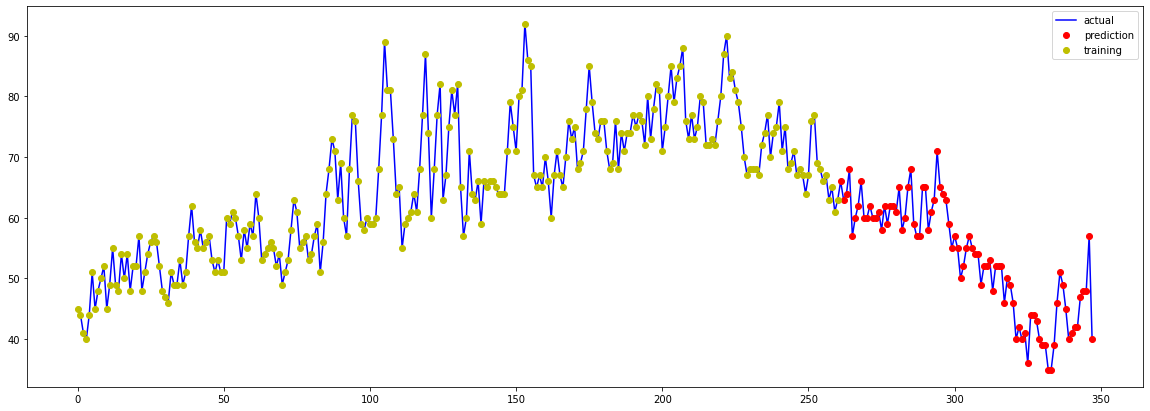

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(range(348), y, 'b-', label = 'actual')
plt.plot(y_test.index, y_test, 'ro', label = 'prediction')
plt.plot(y_train.index, y_train, 'yo', label = 'training')
plt.legend()

In [ ]:
model = tree.DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

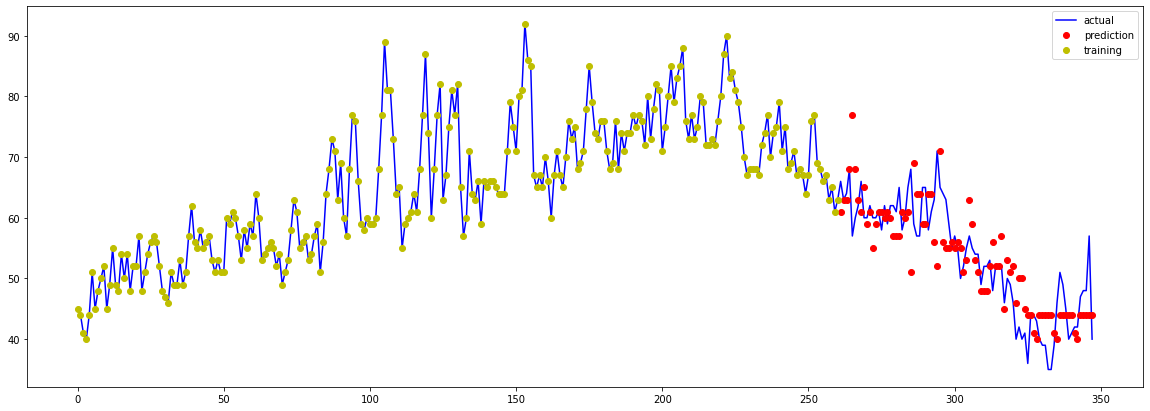

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(range(348), y, 'b-', label = 'actual')
plt.plot(y_test.index, y_pred, 'ro', label = 'prediction')
plt.plot(y_train.index, y_train, 'yo', label = 'training')
plt.legend()

In [ ]:
errors = abs(y_pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 4.53 degrees.


In [ ]:
print(np.percentile(errors, 50))
print(np.percentile(errors, 90))

4.0
8.0


In [ ]:
mape = 100*mean_absolute_percentage_error(y_test, y_pred)

accuracy = 100 - np.mean(mape)

print('MAPE: ', mape, '%.')
print('Accuracy:', round(accuracy, 2), '%.')

MAPE:  8.692883997546302 %.
Accuracy: 91.31 %.


In [ ]:
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Variance score: 0.57


## Agora, considerando como uma série temporal e usando validação cruzada

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=False)
tss = TimeSeriesSplit()

Vamos visualizar como o TimesSeriesSplit divide os dados a cada iteração, observando que se mantem a característica de treinar com dados passados e testar com dados futuros.

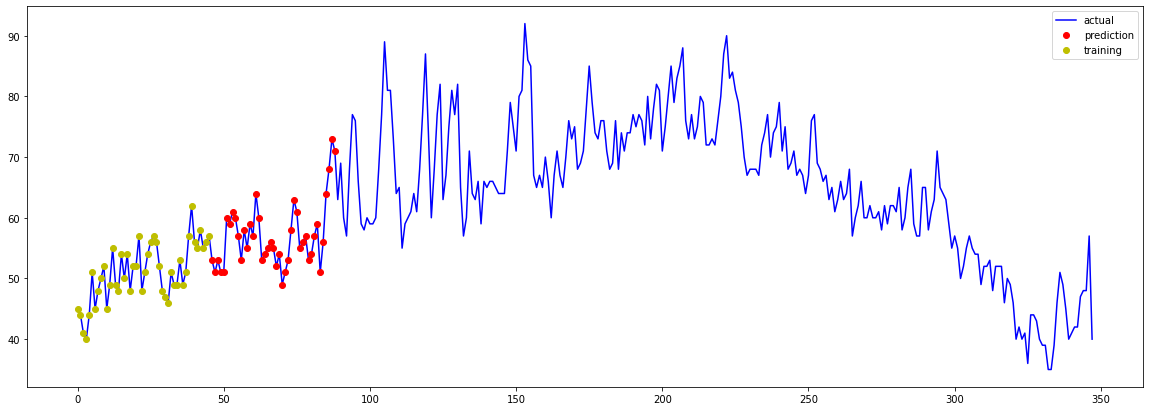

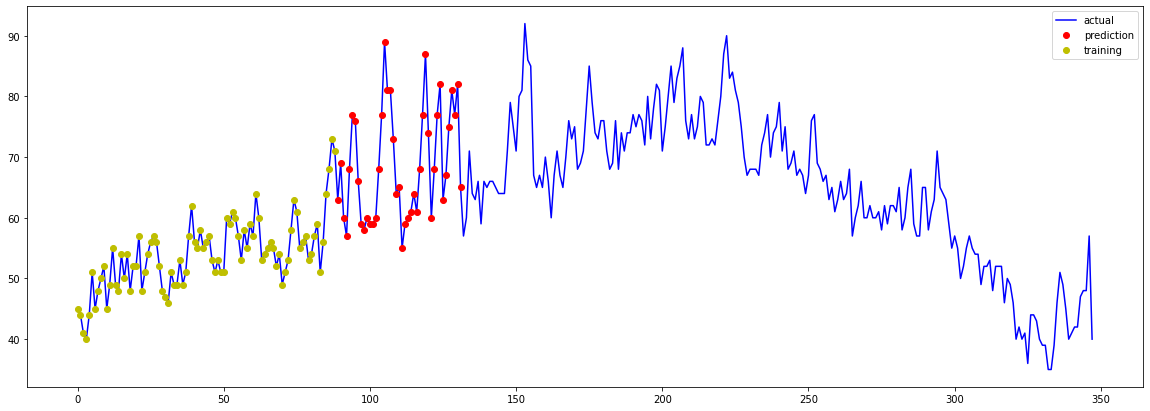

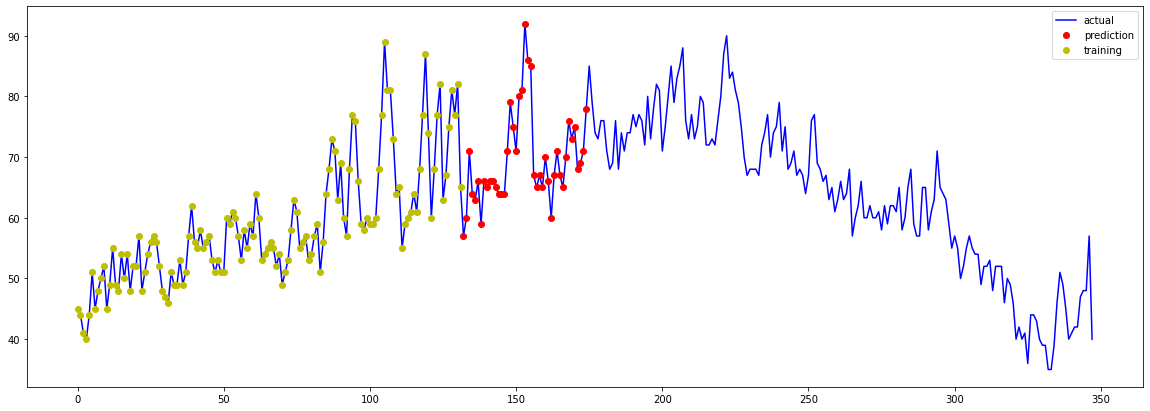

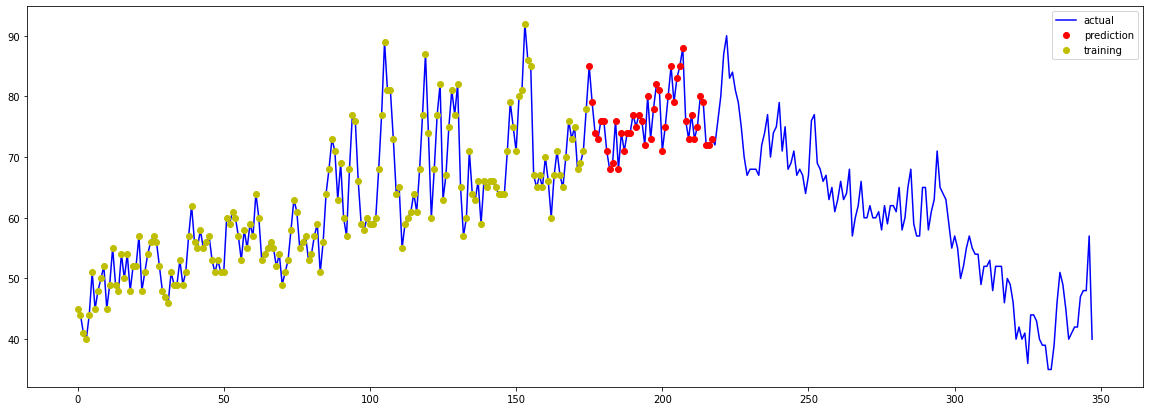

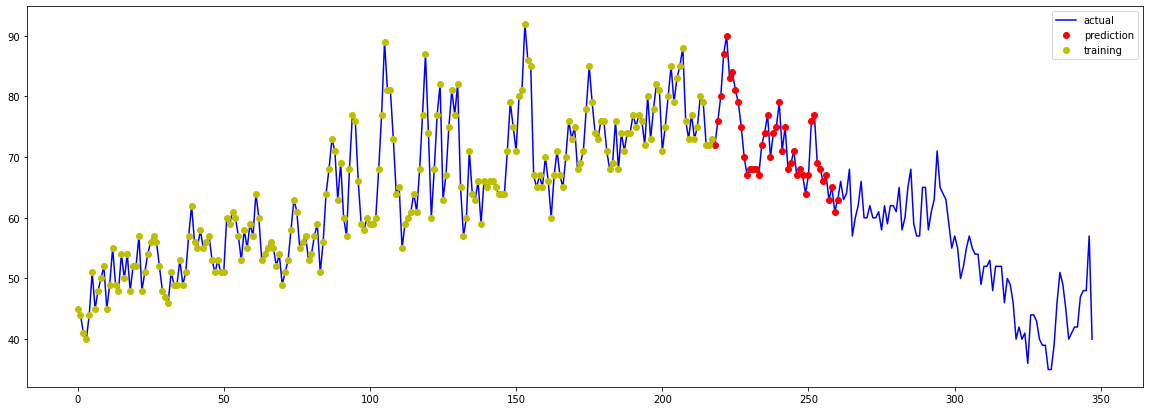

In [ ]:
import matplotlib.pyplot as plt
import datetime

for train_index, test_index in tss.split(X_train):
    plt.figure(figsize=(20, 7))
    plt.plot(range(348), y, 'b-', label = 'actual')
    plt.plot(test_index, y[test_index], 'ro', label = 'prediction')
    plt.plot(train_index, y[train_index], 'yo', label = 'training')
    plt.legend()
    plt.plot()

Observe que, para a validação cruzada, passamos o TSS (TimeSeriesSplit) para o validador (cross_validate) através do parâmetro cv=tss.

In [ ]:
from sklearn import tree
from sklearn.model_selection import cross_validate

model = tree.DecisionTreeRegressor()
scr = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
cv_results = cross_validate(model, X_train, y_train, cv=tss, scoring=scr)
cv_results

{'fit_time': array([0.01913953, 0.00696468, 0.0039916 , 0.00384259, 0.00414133]),
 'score_time': array([0.00638032, 0.00310636, 0.00276899, 0.00267053, 0.00325966]),
 'test_neg_mean_absolute_error': array([-5.30232558, -8.62790698, -7.41860465, -6.69767442, -5.44186047]),
 'test_neg_root_mean_squared_error': array([-6.48432816, -9.62192264, -9.73724568, -8.67501089, -6.65774597]),
 'test_r2': array([-0.5180817 , -0.13750415, -0.73437871, -2.43575309, -0.01387995])}

In [ ]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_neg_mean_absolute_error', 'test_neg_root_mean_squared_error', 'test_r2'])

In [ ]:
cv_results['test_neg_mean_absolute_error']

array([-5.30232558, -8.62790698, -7.41860465, -6.69767442, -5.44186047])

In [ ]:
print('MAE: ', -1*cv_results['test_neg_mean_absolute_error'].mean())
print('RMSE: ', -1*cv_results['test_neg_root_mean_squared_error'].mean())

MAE:  6.6976744186046515
RMSE:  8.235250668328455


Após a validação cruzada, quando já temos os resultados médios, retreinamos o modelo com todos os dados de treinamento e testamos nos dados de treino e teste. 

In [ ]:
import matplotlib.pyplot as plt
import datetime

y_train_pred = model.fit(X_train, y_train).predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_train_pred)
mse = mean_squared_error(y_test, y_train_pred)
rmse = mean_squared_error(y_test, y_train_pred, squared=False)
mape = 100*mean_absolute_percentage_error(y_test, y_train_pred)
r2 = r2_score(y_test, y_train_pred)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE: ', mape, '%.')
print('Variance score: %.2f' % r2)

MAE: 4.333333333333333
MSE: 33.50574712643678
RMSE: 5.78841490621023
MAPE:  8.412580517094918 %.
Variance score: 0.60


Este resultado em treinamento pode ser considerado dentro da normalidade de árvores de decisão, porém mostram que o modelo se adaptou completamente aos dados, o que, sabemos, pode não ser bom.

Vamos verificar então os resultados na base de testes

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = 100*mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE: ', mape, '%.')
print('Variance score: %.2f' % r2)

MAE: 4.528735632183908
MSE: 35.42528735632184
RMSE: 5.951914595852484
MAPE:  8.692883997546302 %.
Variance score: 0.57


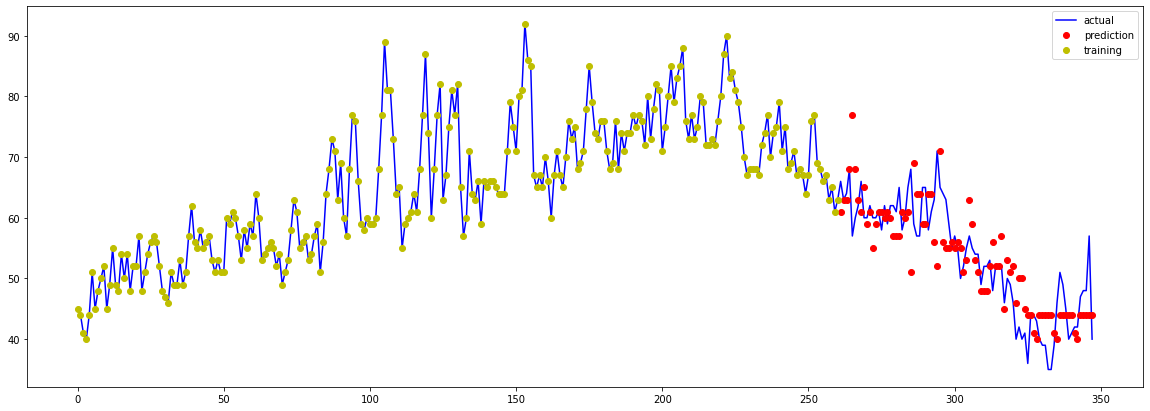

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(range(348), y, 'b-', label = 'actual')
plt.plot(y_test.index, y_pred, 'ro', label = 'prediction')
plt.plot(y_train.index, y_train, 'yo', label = 'training')
plt.legend()

## Vamos testar variações na árvore de decisão para verificar se conseguimos melhorar os resultados.

Sempre ressaltando que estaremos olhando para os resultados da validação cruzada para melhorar o nosso modelo. Não para os resultados em teste.
Nós queremos que os resultados em teste estejam compatíveis com os resultados da validação cruzada. 

Para isto, usaremos 2 ferramentas importantes do sklearn: Pipeline e GridSearchCV.

Pipeline executa um pipeline de dados, um fluxo de dados que pode ir da captura aos resultados, passando por todas as etapas. Aqui executaremos apenas a modelagem.

GridSearchCV executa a validação cruzada ao mesmo tempo que busca por melhores parâmetros do modelo, o que é chamado de hiperparametrização.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

search_paramns = [{
    'tree__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'tree__splitter': ['best', 'random'],
    'tree__max_features': ['auto', 'sqrt', 'log2'],
    'tree__max_depth': [None, 2, 3, 5]}]

pipe = Pipeline([
    ('tree', tree.DecisionTreeRegressor())])

tss = TimeSeriesSplit()

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=tss,
                     scoring='neg_root_mean_squared_error')

### Treinando e calibrando hiperparâmetros do modelo

In [ ]:
%%time
search.fit(X_train, y_train)

CPU times: user 3.26 s, sys: 20.8 ms, total: 3.28 s
Wall time: 3.29 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('tree', DecisionTreeRegressor())]),
             param_grid=[{'tree__criterion': ['squared_error', 'friedman_mse',
                                              'absolute_error', 'poisson'],
                          'tree__max_depth': [None, 2, 3, 5],
                          'tree__max_features': ['auto', 'sqrt', 'log2'],
                          'tree__splitter': ['best', 'random']}],
             scoring='neg_root_mean_squared_error')

In [ ]:
search.cv_results_

{'mean_fit_time': array([0.00518041, 0.00519075, 0.00362906, 0.00446529, 0.00477109,
        0.00336852, 0.00327101, 0.00318947, 0.00300989, 0.0029213 ,
        0.0037303 , 0.00298615, 0.00322189, 0.00301204, 0.00309911,
        0.00349536, 0.00322051, 0.0045568 , 0.00376701, 0.00353289,
        0.00315471, 0.00289969, 0.00318236, 0.00325947, 0.0039289 ,
        0.00367737, 0.00430932, 0.0032917 , 0.00464349, 0.00324926,
        0.003339  , 0.0034935 , 0.00320067, 0.00321703, 0.00297971,
        0.00389452, 0.00326381, 0.00310702, 0.00375133, 0.00313706,
        0.00312338, 0.00341177, 0.00348716, 0.00314412, 0.00312724,
        0.00301747, 0.00310965, 0.00359535, 0.00878353, 0.00683575,
        0.00517044, 0.00420136, 0.00459957, 0.00420866, 0.00497537,
        0.00394559, 0.00341878, 0.00331001, 0.00337167, 0.00330663,
        0.00498219, 0.00428009, 0.00402193, 0.00348721, 0.00437098,
        0.00335164, 0.00619125, 0.00480022, 0.00387511, 0.00351152,
        0.00382295, 0.0051909 ,

In [ ]:
search.cv_results_.get('mean_test_score')

array([ -8.6754598 ,  -9.3166024 ,  -9.29039265,  -8.41638195,
        -9.00578743, -10.36958572,  -6.44739812,  -8.04091164,
        -7.24005507,  -8.62733049,  -7.69564042,  -7.97455355,
        -6.72714329,  -7.04738292,  -7.98707574,  -7.61626232,
        -7.93741434,  -8.25179419,  -7.79517772,  -8.03681185,
        -7.61128691,  -8.36812463,  -8.02225206,  -9.65280508,
        -8.80916849,  -8.84056357,  -9.21350032,  -9.10227307,
        -8.73891902,  -8.1915473 ,  -6.44739812,  -7.78455254,
        -7.65970104,  -8.76178155,  -8.10478086,  -8.53558344,
        -6.72714329,  -6.66581771,  -7.35607004,  -8.63873406,
        -7.18419852,  -7.71858144,  -8.09825738,  -7.34837183,
        -8.47433717,  -9.36495741,  -7.99358203,  -8.25710661,
        -8.97467696,  -8.96479706,  -8.54178747,  -7.60272508,
        -9.28867844,  -8.51435162,  -6.49686777,  -7.89499125,
        -9.89196219,  -9.95175871,  -8.67206363,  -8.29043167,
        -7.62668963,  -6.85124203,  -7.95996885,  -7.55

In [ ]:
search.best_params_

{'tree__criterion': 'squared_error',
 'tree__max_depth': 2,
 'tree__max_features': 'auto',
 'tree__splitter': 'best'}

### Visualizando os resultados e avaliando o modelo

O GridSearchCV já nos fornece o melhor modelo alcançado, treinado em toda a base de treinamento (X_train), para que possamos utilizar.

In [ ]:
y_train_pred = search.predict(X_train)

mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
mape = 100*mean_absolute_percentage_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE: ', mape, '%.')
print('Variance score: %.2f' % r2)

MAE: 4.24488658981474
MSE: 26.771655748108856
RMSE: 5.174133333043212
MAPE:  6.651494697233167 %.
Variance score: 0.77


In [ ]:
y_pred = search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = 100*mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE: ', mape, '%.')
print('Variance score: %.2f' % r2)

MAE: 7.212909511630741
MSE: 80.25417897395941
RMSE: 8.95846967812915
MAPE:  15.443702660559067 %.
Variance score: 0.01


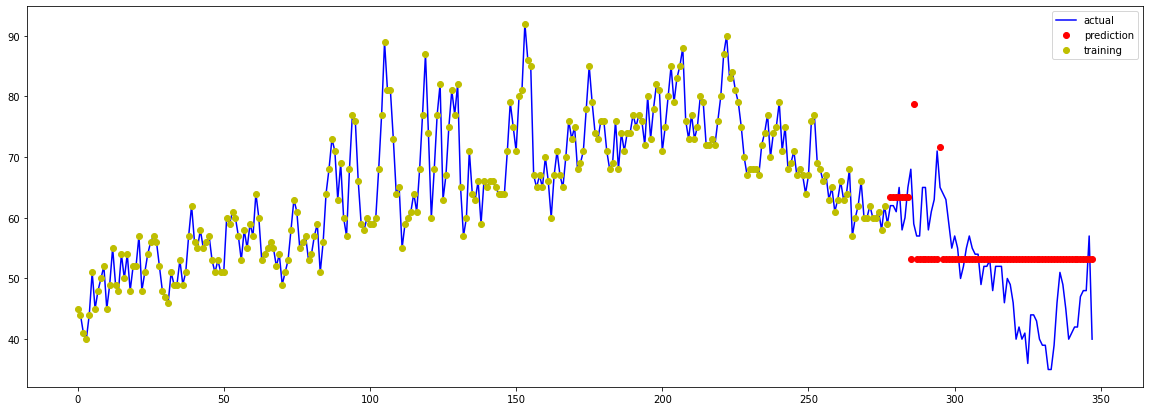

In [ ]:
import matplotlib.pyplot as plt
import datetime

plt.figure(figsize=(20, 7))
plt.plot(range(348), y, 'b-', label = 'actual')
plt.plot(y_test.index, y_pred, 'ro', label = 'prediction')
plt.plot(y_train.index, y_train, 'yo', label = 'training')
plt.legend()

[Text(0.5482234286723164, 0.9705882352941176, 'X[4] <= 66.5\nsquared_error = 114.872\nsamples = 278\nvalue = 65.32'),
 Text(0.26490112994350284, 0.9117647058823529, 'X[5] <= 55.55\nsquared_error = 45.412\nsamples = 148\nvalue = 57.514'),
 Text(0.13453389830508475, 0.8529411764705882, 'X[5] <= 49.25\nsquared_error = 23.698\nsamples = 85\nvalue = 53.176'),
 Text(0.046610169491525424, 0.7941176470588235, 'X[5] <= 46.05\nsquared_error = 17.036\nsamples = 38\nvalue = 49.737'),
 Text(0.01807909604519774, 0.7352941176470589, 'X[11] <= 0.5\nsquared_error = 3.76\nsamples = 5\nvalue = 42.8'),
 Text(0.013559322033898305, 0.6764705882352942, 'X[13] <= 0.5\nsquared_error = 2.25\nsamples = 4\nvalue = 43.5'),
 Text(0.00903954802259887, 0.6176470588235294, 'X[9] <= 35.0\nsquared_error = 0.222\nsamples = 3\nvalue = 44.333'),
 Text(0.004519774011299435, 0.5588235294117647, 'squared_error = 0.0\nsamples = 1\nvalue = 45.0'),
 Text(0.013559322033898305, 0.5588235294117647, 'squared_error = 0.0\nsamples = 2

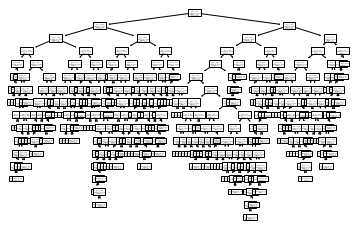

In [ ]:
model = tree.DecisionTreeClassifier() # Cria árvore para classificação
model = tree.DecisionTreeRegressor() # Cria árvore para regressão

model.fit(X_train,y_train) # Cria a árvore baseada nos dados de treinamento
predictions = model.predict(X_test) # Prediz a saída dos dados de teste
tree.plot_tree(model) # Plota a árvore de 


## Conclusão

Note como o modelo foi ruim na base de testes, desvinculando-se totalmente dos resultados da validação.
Isto mostra que saímos de um modelo que sofria de overfitting para um modelo que sobre de underfitting, simplificando demais o aprendizado, o que provavelmente ocorreu pelo modelo ter poucos dados abaixo da temperatura de aproximadamente 55.

Neste momento, indica-se a utilização de modelos mais complexos, como o RandomForests e o GBDT. 

## Iniciando RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
np.random.seed(0)

In [ ]:
temps = pd.read_csv('temps.csv')
temps.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


## GridSearchCV para verificar melhores parâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import ensemble

search_paramns = [{
    'max_depth': [5,15,50,100,50],
    'min_samples_split': [2,3,4,5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [None, 2, 3, 4]}]

#tss = TimeSeriesSplit()

search = GridSearchCV(estimator=RandomForestRegressor(),
                     param_grid=search_paramns,
                     cv=5,
                     scoring='neg_root_mean_squared_error')

In [ ]:
%%time
search.fit(X_train, y_train)

CPU times: user 2min 37s, sys: 1 s, total: 2min 38s
Wall time: 2min 38s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [5, 15, 50, 100, 50],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_leaf': [None, 2, 3, 4],
                          'min_samples_split': [2, 3, 4, 5]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
search.cv_results_

{'mean_fit_time': array([0.04416728, 0.04132514, 0.04222813, 0.04319234, 0.17072206,
        0.16984754, 0.16875396, 0.17120576, 0.16388173, 0.16414595,
        0.16725001, 0.16519589, 0.16089649, 0.16036282, 0.16508608,
        0.16781635, 0.0419785 , 0.04181204, 0.03973546, 0.03975568,
        0.13400545, 0.13399973, 0.14006543, 0.13330736, 0.13236952,
        0.1338057 , 0.13017735, 0.13408365, 0.13387532, 0.13300557,
        0.13262973, 0.13091345, 0.03954582, 0.04156256, 0.04243994,
        0.03939466, 0.13786287, 0.13090215, 0.13347559, 0.13447752,
        0.13393922, 0.13537564, 0.13281693, 0.13223519, 0.13296685,
        0.13167253, 0.13371878, 0.1296392 , 0.04803281, 0.04145885,
        0.03962083, 0.04178786, 0.1898962 , 0.18740802, 0.18853784,
        0.19091592, 0.18696442, 0.1798254 , 0.17926512, 0.17616801,
        0.17098651, 0.17394247, 0.17129755, 0.16677637, 0.0428225 ,
        0.04070663, 0.04224734, 0.04125543, 0.1492466 , 0.14879022,
        0.14289823, 0.13936677,

In [ ]:
search.cv_results_.get('mean_test_score')

array([        nan,         nan,         nan,         nan, -6.22598194,
       -6.22290733, -6.28185319, -6.20405083, -6.24135217, -6.20000831,
       -6.14249925, -6.22232098, -6.07713903, -6.0586762 , -6.14932369,
       -6.18147306,         nan,         nan,         nan,         nan,
       -6.271072  , -6.16851959, -6.13589433, -6.15406562, -6.17484139,
       -6.15284557, -6.01536416, -6.21495408, -6.17023708, -6.16661727,
       -6.09001477, -6.12302093,         nan,         nan,         nan,
               nan, -6.19390942, -6.14475292, -6.13435702, -6.22329253,
       -6.12510455, -6.15756418, -6.21680511, -6.15263977, -6.04860279,
       -6.08327847, -6.18317654, -6.07112115,         nan,         nan,
               nan,         nan, -6.23899955, -6.22732179, -6.16482676,
       -6.2765733 , -6.21804072, -6.16810537, -6.05526025, -6.25173918,
       -6.11590076, -6.10899657, -6.08990678, -6.13230741,         nan,
               nan,         nan,         nan, -6.06793263, -6.02

## Resultado de melhores parâmetros

In [ ]:
search.best_params_

{'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 3}

In [ ]:
y_train_pred = search.predict(X_train)

mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
mape = 100*mean_absolute_percentage_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE: ', mape, '%.')
print('Variance score: %.2f' % r2)

MAE: 2.8722728867603826
MSE: 13.541679591332244
RMSE: 3.679902117085758
MAPE:  4.384709438848283 %.
Variance score: 0.88


In [ ]:
y_pred = search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = 100*mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE: ', mape, '%.')
print('Variance score: %.2f' % r2)

MAE: 4.99222419794197
MSE: 41.005460018580386
RMSE: 6.403550579060057
MAPE:  10.98402451873959 %.
Variance score: 0.49


## Aplicação do RandomForestRegressor com melhores parâmetros

In [ ]:
reg = RandomForestRegressor(max_depth= 15,
 max_features= 'log2',
 min_samples_leaf= 4,
 min_samples_split= 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=False)

In [ ]:
reg.fit(X_train,y_train)

RandomForestRegressor(max_depth=15, max_features='log2', min_samples_leaf=4,
                      min_samples_split=3)

In [ ]:
tempPredict =  reg.predict(X_test)

## Score RandomForest com melhores parâmetros

In [ ]:
reg.score(X_test, y_test)

0.544405680293693

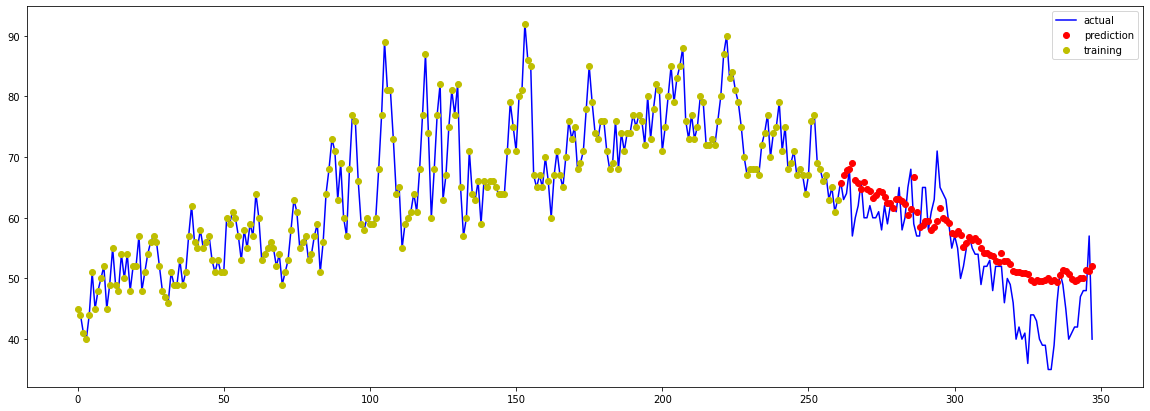

In [ ]:
import matplotlib.pyplot as plt
import datetime

plt.figure(figsize=(20, 7))
plt.plot(range(348), y, 'b-', label = 'actual')
plt.plot(y_test.index, tempPredict, 'ro', label = 'prediction')
plt.plot(y_train.index, y_train, 'yo', label = 'training')
plt.legend()

## Observamos pelo gráfico uma predição relativamente baixa, visto o score ser também baixo.

## Iniciando o GradientBooster para verificar melhor performance

## Score GradientBooster sem GridSearchCV

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
np.random.seed(0)
from sklearn.model_selection import train_test_split

reg = GradientBoostingRegressor(random_state=0)
 
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

reg.score(X_test, y_test)

0.6456797765929827

## Iniciando GradientBooster com GridSearchCV para obter melhores parâmetros




In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import ensemble

search_paramns = [{
    'max_depth': [5,15,50,100,500], #5,15,50,100,500
    'min_samples_split': [2,3,4,5], #2,3,4,5
    'max_features': ['auto', 'sqrt', 'log2'], 
    'min_samples_leaf': [None, 2, 3, 4]}] #None, 2, 3, 4

#tss = TimeSeriesSplit()

search = GridSearchCV(estimator=GradientBoostingRegressor(),
                     param_grid=search_paramns,
                     cv=5,
                     scoring='neg_root_mean_squared_error')

In [ ]:
%%time
search.fit(X_train, y_train)

CPU times: user 1min 18s, sys: 175 ms, total: 1min 18s
Wall time: 1min 19s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 596, in fit
    monitor,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 672, in _fit_stages
    X_csr,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 246, in _fit_stage
    t

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid=[{'max_depth': [5, 15, 50, 100, 500],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_leaf': [None, 2, 3, 4],
                          'min_samples_split': [2, 3, 4, 5]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
search.cv_results_

{'mean_fit_time': array([0.00366402, 0.00297642, 0.00280981, 0.00284405, 0.08875422,
        0.09709916, 0.0884357 , 0.08942208, 0.08321033, 0.0864872 ,
        0.0867919 , 0.08713655, 0.08144879, 0.08192315, 0.08292589,
        0.08259172, 0.00299416, 0.00299592, 0.00296631, 0.00294962,
        0.04515786, 0.04470563, 0.04462428, 0.04463367, 0.04448543,
        0.04399033, 0.04229078, 0.04474907, 0.04344783, 0.04597216,
        0.04229841, 0.04142795, 0.00304561, 0.00286322, 0.00330863,
        0.00282164, 0.04484739, 0.04637594, 0.04788766, 0.04470205,
        0.04380622, 0.04513288, 0.04196048, 0.04356747, 0.04212322,
        0.04278994, 0.04461846, 0.04257293, 0.0028738 , 0.00279093,
        0.00295095, 0.00275326, 0.14822197, 0.14736075, 0.14588041,
        0.16546855, 0.15123305, 0.1520452 , 0.14922447, 0.15135212,
        0.1398787 , 0.14264922, 0.14316421, 0.14302015, 0.00354233,
        0.00326467, 0.00322766, 0.00323644, 0.07818723, 0.09139094,
        0.09217448, 0.09146113,

In [ ]:
search.cv_results_.get('mean_test_score')

array([        nan,         nan,         nan,         nan, -6.51663397,
       -6.60934444, -6.51335347, -6.56386659, -6.54011537, -6.51120852,
       -6.53858139, -6.51204377, -6.56420882, -6.57187485, -6.53022063,
       -6.5462632 ,         nan,         nan,         nan,         nan,
       -6.55370005, -6.71260152, -6.52636049, -6.58805992, -6.54328163,
       -6.59205794, -6.75233783, -6.84017543, -6.55129124, -6.64733246,
       -6.79066921, -6.5622464 ,         nan,         nan,         nan,
               nan, -6.5441196 , -6.63600982, -6.75486823, -6.92457301,
       -6.81591121, -6.68659219, -6.63282066, -6.63383955, -6.47093644,
       -6.56997678, -6.64772972, -6.93238606,         nan,         nan,
               nan,         nan, -6.69176766, -6.67886119, -6.71504662,
       -6.57418735, -6.49606932, -6.58288459, -6.5386054 , -6.67933515,
       -6.61855558, -6.52751738, -6.60103684, -6.54403404,         nan,
               nan,         nan,         nan, -6.48928883, -6.68

## Obtenção dos melhores parâmetros GridSearchCV

In [ ]:
search.best_params_

{'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 3}

In [ ]:
y_train_pred = search.predict(X_train)

mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
mape = 100*mean_absolute_percentage_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE: ', mape, '%.')
print('Variance score: %.2f' % r2)

MAE: 0.00565540881505159
MSE: 0.00014540117226028855
RMSE: 0.012058240844347427
MAPE:  0.008353039993332435 %.
Variance score: 1.00


In [ ]:
y_pred = search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = 100*mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE: ', mape, '%.')
print('Variance score: %.2f' % r2)

MAE: 5.649249086113598
MSE: 51.56819513298772
RMSE: 7.181099855383416
MAPE:  12.110641192695295 %.
Variance score: 0.38


### Iniciando GradientBooster com melhores parâmetros

In [ ]:
reg = GradientBoostingRegressor(max_depth= 100,
 max_features= 'sqrt',
 min_samples_leaf= 2,
 min_samples_split= 3)

In [ ]:
reg.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=100, max_features='sqrt',
                          min_samples_leaf=2, min_samples_split=3)

In [ ]:
tempPredictGBDT = reg.predict(X_test)

## Score GradientBooster com melhores parâmetros

In [ ]:
reg.score(X_test, y_test)

0.5236741140961718

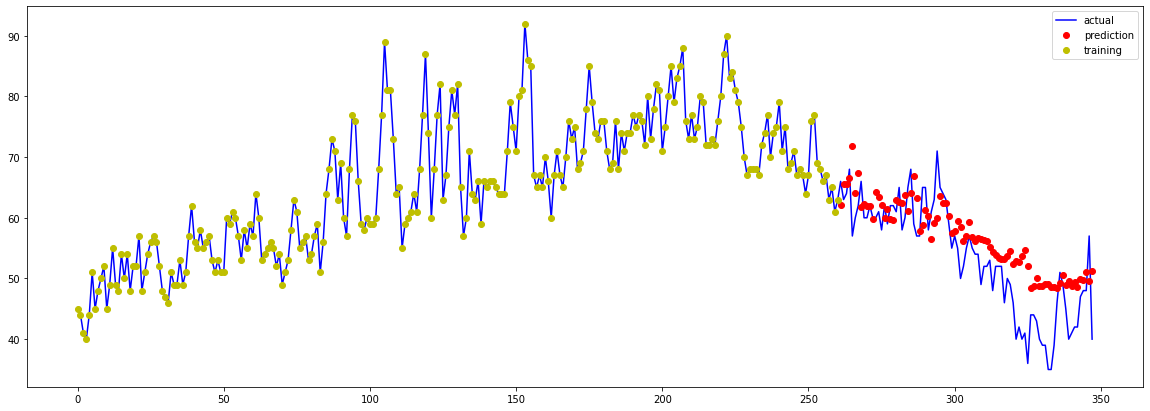

In [ ]:
import matplotlib.pyplot as plt
import datetime

plt.figure(figsize=(20, 7))
plt.plot(range(348), y, 'b-', label = 'actual')
plt.plot(y_test.index, tempPredictGBDT, 'ro', label = 'prediction')
plt.plot(y_train.index, y_train, 'yo', label = 'training')
plt.legend()

## Observamos pelo gráfico uma predição relativamente baixa, visto o score ser também baixo. O RandomForest apresentou leve melhora na predição.

## Iniciando o modelo PLSRegression do **PONTO EXTRA** 

Score inicial 0,58 sem o GridSearchCV

In [ ]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
np.random.seed(0)
from sklearn.model_selection import train_test_split

regPLS = PLSRegression(n_components=2)
 
regPLS.fit(X_train, y_train)

regPLS.score(X_test, y_test)

0.5854313123922521

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.25, shuffle=False)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## Iniciando GridSearchCV para obter os melhores parâmetros

In [ ]:
search_paramns = [{
    'n_components': [1, 2, 3, 4],
    'max_iter': [500, 700],
    'tol': [1e-01, 1e-02,1e-06]}]

#pipe = Pipeline([
    #('tree', tree.DecisionTreeRegressor())])

#tss = TimeSeriesSplit()

search = GridSearchCV(estimator=PLSRegression(),
                     param_grid=search_paramns,cv=5, scoring='neg_root_mean_squared_error')

In [ ]:
%%time
search.fit(X_train2, y_train2)

CPU times: user 918 ms, sys: 5.89 ms, total: 924 ms
Wall time: 939 ms


GridSearchCV(cv=5, estimator=PLSRegression(),
             param_grid=[{'max_iter': [500, 700], 'n_components': [1, 2, 3, 4],
                          'tol': [0.1, 0.01, 1e-06]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
search.cv_results_

{'mean_fit_time': array([0.00645485, 0.00502214, 0.00426512, 0.00415812, 0.00423894,
        0.00422783, 0.00425177, 0.00411134, 0.00412459, 0.00542336,
        0.00429435, 0.00442162, 0.00459714, 0.00392146, 0.00478182,
        0.00471101, 0.00429511, 0.00420084, 0.0043426 , 0.00414052,
        0.00425916, 0.00543218, 0.00416784, 0.00414743]),
 'mean_score_time': array([0.00309052, 0.00334001, 0.0026607 , 0.00237479, 0.00244789,
        0.00256796, 0.00275965, 0.00254254, 0.0023325 , 0.00292878,
        0.00251188, 0.00235019, 0.00282493, 0.00247045, 0.00300398,
        0.00246539, 0.00266113, 0.00266266, 0.00276284, 0.00230484,
        0.00240316, 0.00306864, 0.00264177, 0.00264578]),
 'mean_test_score': array([-5.93926218, -5.93926218, -5.93926218, -5.78964372, -5.78964372,
        -5.78964372, -5.29418888, -5.29418888, -5.29418888, -5.11045884,
        -5.11045884, -5.11045884, -5.93926218, -5.93926218, -5.93926218,
        -5.78964372, -5.78964372, -5.78964372, -5.29418888, -5.294

In [ ]:
search.cv_results_.get('mean_test_score')

array([-5.93926218, -5.93926218, -5.93926218, -5.78964372, -5.78964372,
       -5.78964372, -5.29418888, -5.29418888, -5.29418888, -5.11045884,
       -5.11045884, -5.11045884, -5.93926218, -5.93926218, -5.93926218,
       -5.78964372, -5.78964372, -5.78964372, -5.29418888, -5.29418888,
       -5.29418888, -5.11045884, -5.11045884, -5.11045884])

## Melhores parâmetros do GridSearchCV

In [ ]:
search.best_params_

{'max_iter': 500, 'n_components': 4, 'tol': 0.1}

In [ ]:
y_train_pred_PLS = search.predict(X_train2)

mae = mean_absolute_error(y_train2, y_train_pred_PLS)
mse = mean_squared_error(y_train, y_train_pred_PLS)
rmse = mean_squared_error(y_train2, y_train_pred_PLS, squared=False)
mape = 100*mean_absolute_percentage_error(y_train2, y_train_pred_PLS)
r2 = r2_score(y_train, y_train_pred)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE: ', mape, '%.')
print('Variance score: %.2f' % r2)

MAE: 3.6565794257742654
MSE: 22.33156307456026
RMSE: 4.725628325901251
MAPE:  5.6056516922858135 %.
Variance score: 1.00


In [ ]:
y_pred2 = search.predict(X_test2)

mae = mean_absolute_error(y_test2, y_pred2)
mse = mean_squared_error(y_test2, y_pred2)
rmse = mean_squared_error(y_test2, y_pred2, squared=False)
mape = 100*mean_absolute_percentage_error(y_test2, y_pred2)
r2 = r2_score(y_test2, y_pred2)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE: ', mape, '%.')
print('Variance score: %.2f' % r2)

MAE: 3.9932359260898296
MSE: 38.89323723265155
RMSE: 6.2364442780042175
MAPE:  7.429358966885551 %.
Variance score: 0.53


In [ ]:
regPLS = PLSRegression(max_iter= 500, n_components= 4, tol=0.1)

In [ ]:
regPLS.fit(X_train2,y_train2)

PLSRegression(n_components=4, tol=0.1)

In [ ]:
tempPredictPLS = regPLS.predict(X_test2)

In [ ]:
regPLS.score(X_test, y_test)

0.5314552586791816

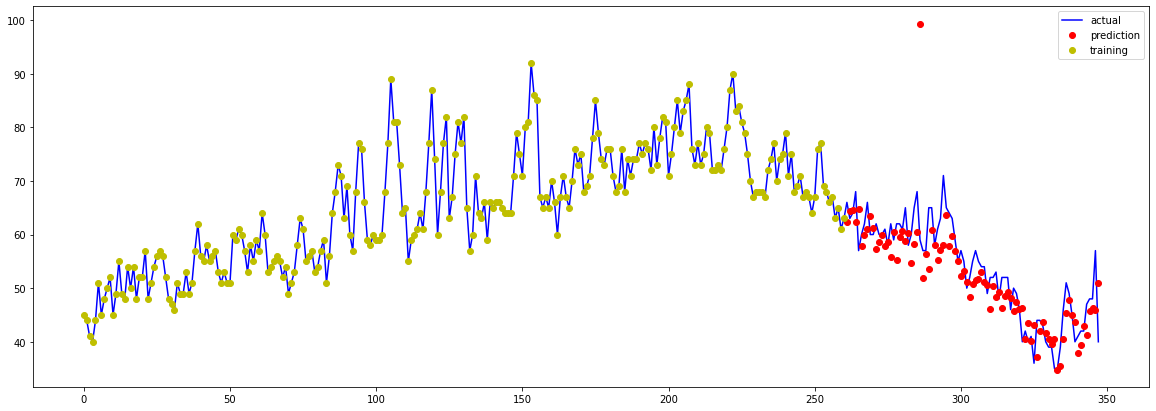

In [ ]:
import matplotlib.pyplot as plt
import datetime

plt.figure(figsize=(20, 7))
plt.plot(range(348), y, 'b-', label = 'actual')
plt.plot(y_test2.index, tempPredictPLS, 'ro', label = 'prediction')
plt.plot(y_train2.index, y_train2, 'yo', label = 'training')
plt.legend()

## Apesar do outlier, observamos que a distribuição da predição com o PLSRegression é mais fidedigno com a reta "Actual".

## Conclusão

Observamos que após os 4 modelos, o randomForest apresentou o melhor resultado, após obtenção dos melhores parâmetros com o GridSearchCV.
Com o score de 0.54